In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv('../data/BrentOilPrices.csv')

# FIX: Try multiple formats, use the one that works
def smart_date_parser(date_str):
    """Try different date formats until one works"""
    
    # List of possible formats your data might be in
    formats = [
        '%b %d, %Y',    # Apr 22, 2020
        '%d-%b-%y',     # 22-Apr-20
        '%Y-%m-%d',     # 2020-04-22
        '%m/%d/%Y',     # 04/22/2020
        '%d/%m/%Y',     # 22/04/2020
        '%B %d, %Y',    # April 22, 2020
    ]
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    
    # If all fail, try pandas automatic detection
    return pd.to_datetime(date_str, errors='coerce')

# Apply the parser
df['Date'] = df['Date'].astype(str).apply(smart_date_parser)

# Drop any rows where date conversion failed
df = df.dropna(subset=['Date'])

# Sort by date
df = df.sort_values('Date')

# Show data
print(f"Data from {df['Date'].min()} to {df['Date'].max()}")
print(f"Total days: {len(df)}")
print(df.head())

Data from 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total days: 9011
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


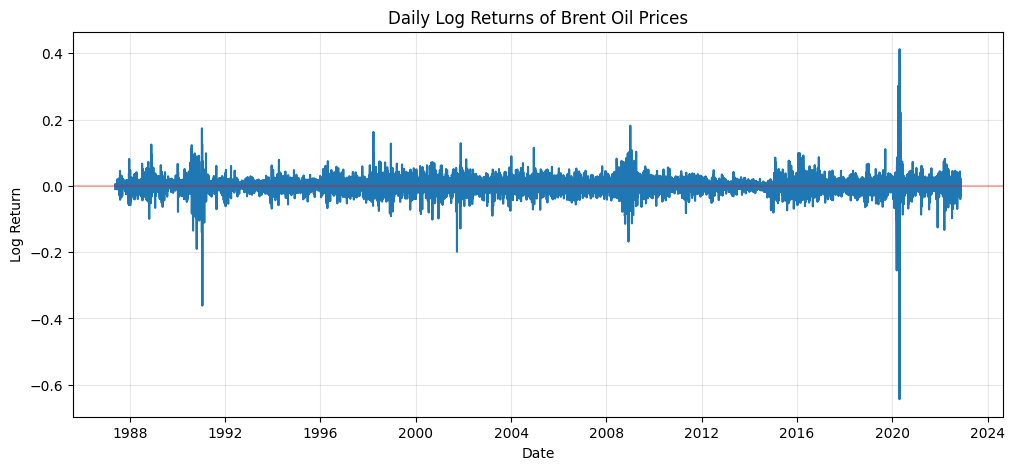

Log returns stats:
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
25%        -0.011154
50%         0.000402
75%         0.012127
max         0.412023
Name: log_return, dtype: float64


In [3]:
# Calculate log returns: log(price_today) - log(price_yesterday)
df['log_return'] = np.log(df['Price']) - np.log(df['Price'].shift(1))

# Remove first row (has NaN)
df = df.dropna()

# Plot log returns
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['log_return'])
plt.title('Daily Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show()

print("Log returns stats:")
print(df['log_return'].describe())

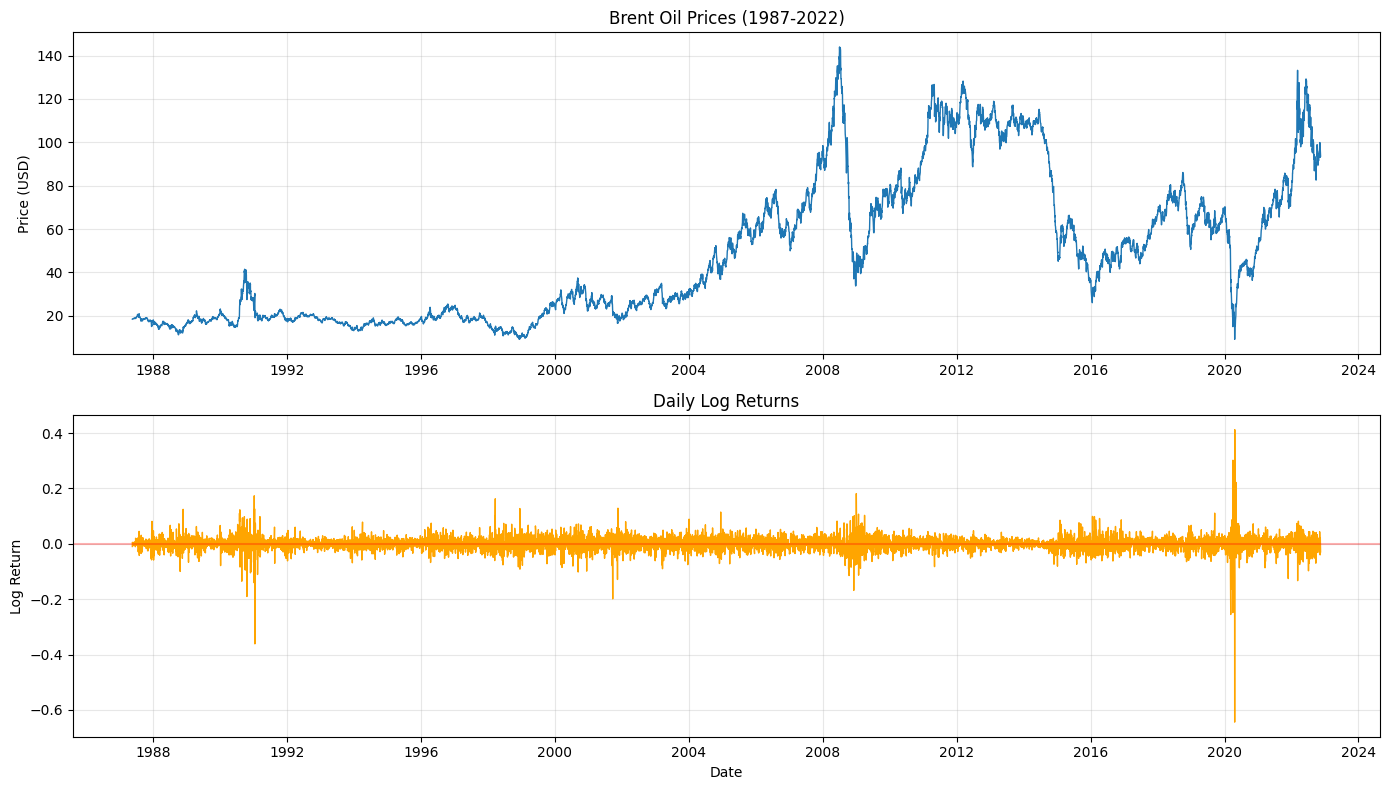

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Original prices
axes[0].plot(df['Date'], df['Price'], linewidth=1)
axes[0].set_title('Brent Oil Prices (1987-2022)')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Log returns
axes[1].plot(df['Date'], df['log_return'], linewidth=1, color='orange')
axes[1].set_title('Daily Log Returns')
axes[1].set_ylabel('Log Return')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
import pymc as pm
import arviz as az


In [6]:
import pytensor
pytensor.config.cxx = ""  # This bypasses the MinGW error

print(f" C compiler disabled. Using Python mode.")
print(f" PyTensor config: cxx = '{pytensor.config.cxx}'")

 C compiler disabled. Using Python mode.
 PyTensor config: cxx = ''


In [7]:
# Extract price data as numpy array
price_data = df['Price'].values

# Get number of data points
n_obs = len(price_data)

print(f"Number of observations: {n_obs}")

Number of observations: 9010


In [8]:
with pm.Model() as single_change_point_model:
    
    # 1. Define the change point (τ)
    # It can be any day except first and last
    tau = pm.DiscreteUniform("tau", lower=1, upper=n_obs-1)
    
    # 2. Define means before and after change
    mu1 = pm.Normal("mu1", mu=50, sigma=20)  # Before change
    mu2 = pm.Normal("mu2", mu=50, sigma=20)  # After change
    
    # 3. Define standard deviation (same before/after for simplicity)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # 4. Create switch: μ₁ before τ, μ₂ after τ
    # This creates an array of means for each time point
    mean = pm.math.switch(tau > np.arange(n_obs), mu1, mu2)
    
    # 5. Define likelihood (observations)
    likelihood = pm.Normal("likelihood", mu=mean, sigma=sigma, observed=price_data)
    
    # 6. Print model structure
    print("Model built successfully!")
    print(f"Model has {len(single_change_point_model.basic_RVs)} random variables")

Model built successfully!
Model has 5 random variables


In [9]:
# Sample from the posterior
with single_change_point_model:
    # Run the sampler
    trace = pm.sample(
    draws=1000,
    tune=500,
    chains=2,
    cores=1,
    random_seed=42,
    progressbar=True    
)
    
print("Sampling completed!")

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 20988 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling completed!


In [10]:
# Summary statistics
summary = az.summary(trace)
print("Model Summary:")
print(summary)

# Check r_hat values (should be close to 1.0)
print("\nR_hat values (all should be ~1.0):")
print(summary['r_hat'])

Model Summary:
           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    4519.852  2.923  4515.000  4525.000      0.139    0.091     447.0   
mu1      21.436  0.287    20.903    21.967      0.006    0.007    2241.0   
mu2      75.603  0.285    75.085    76.139      0.006    0.006    2185.0   
sigma    18.593  0.136    18.348    18.849      0.003    0.003    2230.0   

       ess_tail  r_hat  
tau       398.0    1.0  
mu1      1460.0    1.0  
mu2      1253.0    1.0  
sigma    1449.0    1.0  

R_hat values (all should be ~1.0):
tau      1.0
mu1      1.0
mu2      1.0
sigma    1.0
Name: r_hat, dtype: float64


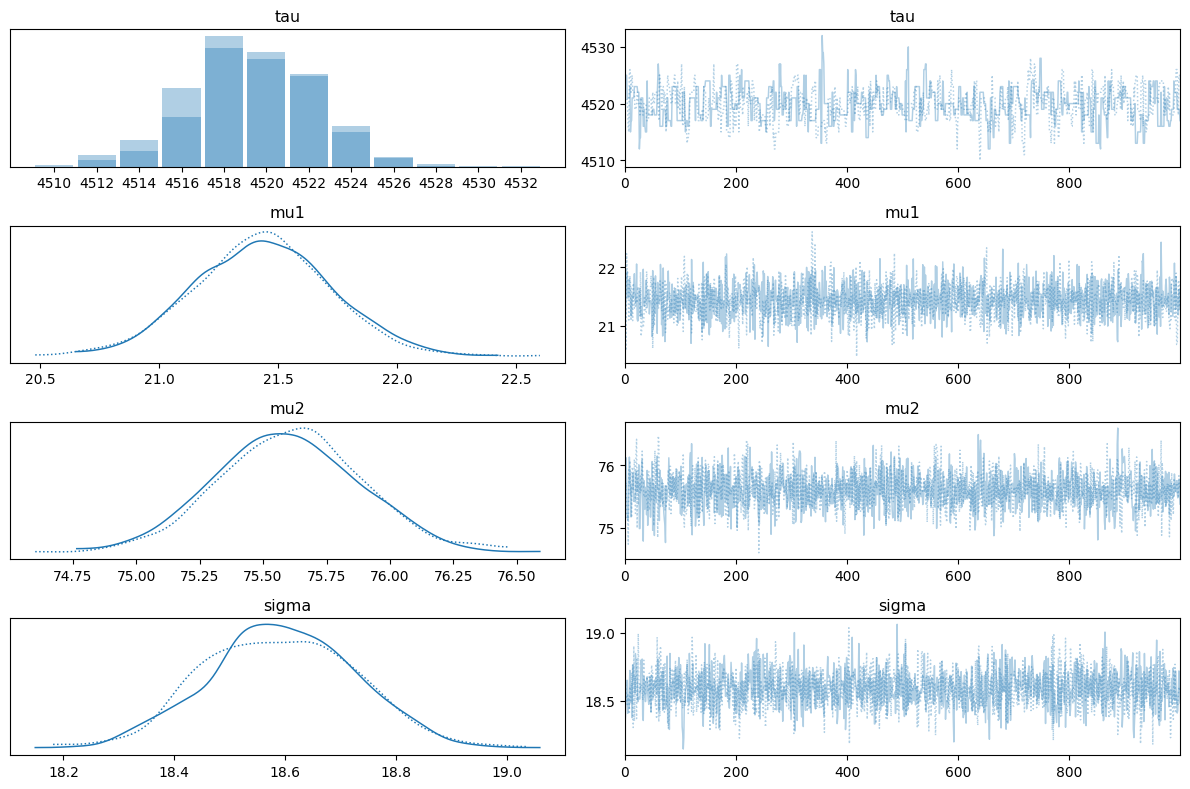

In [11]:
# Plot trace plots
az.plot_trace(trace)
plt.tight_layout()
plt.show()

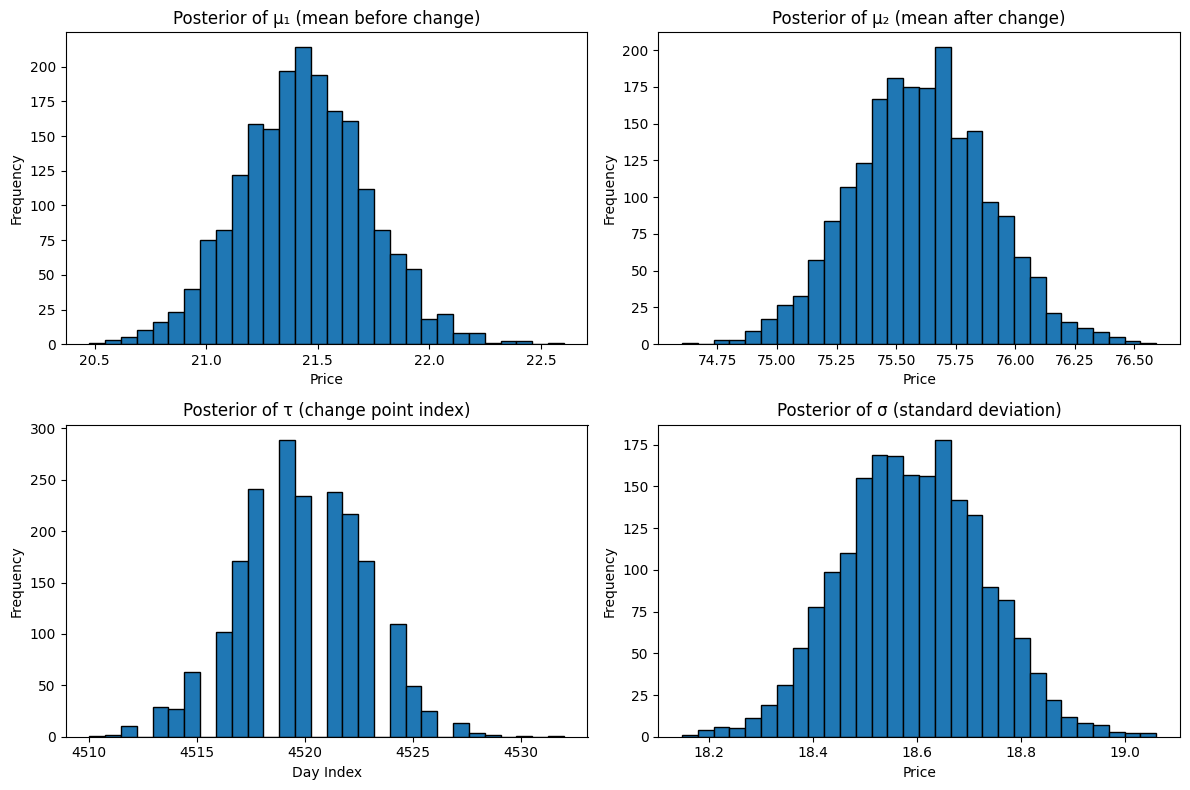

In [12]:
# Plot posterior distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# mu1 posterior
axes[0, 0].hist(trace.posterior['mu1'].values.flatten(), bins=30, edgecolor='black')
axes[0, 0].set_title('Posterior of μ₁ (mean before change)')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# mu2 posterior
axes[0, 1].hist(trace.posterior['mu2'].values.flatten(), bins=30, edgecolor='black')
axes[0, 1].set_title('Posterior of μ₂ (mean after change)')
axes[0, 1].set_xlabel('Price')
axes[0, 1].set_ylabel('Frequency')

# tau posterior
axes[1, 0].hist(trace.posterior['tau'].values.flatten(), bins=30, edgecolor='black')
axes[1, 0].set_title('Posterior of τ (change point index)')
axes[1, 0].set_xlabel('Day Index')
axes[1, 0].set_ylabel('Frequency')

# sigma posterior
axes[1, 1].hist(trace.posterior['sigma'].values.flatten(), bins=30, edgecolor='black')
axes[1, 1].set_title('Posterior of σ (standard deviation)')
axes[1, 1].set_xlabel('Price')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Get the most frequent tau value (mode of posterior)
tau_samples = trace.posterior['tau'].values.flatten()
most_probable_tau = int(np.bincount(tau_samples).argmax())

print(f"Most probable change point index: {most_probable_tau}")

# Convert index to actual date
change_date = df['Date'].iloc[most_probable_tau]
print(f"Change point date: {change_date.date()}")

# Get price on that date
price_at_change = df['Price'].iloc[most_probable_tau]
print(f"Price on change date: ${price_at_change:.2f}")

Most probable change point index: 4519
Change point date: 2005-02-23
Price on change date: $48.16


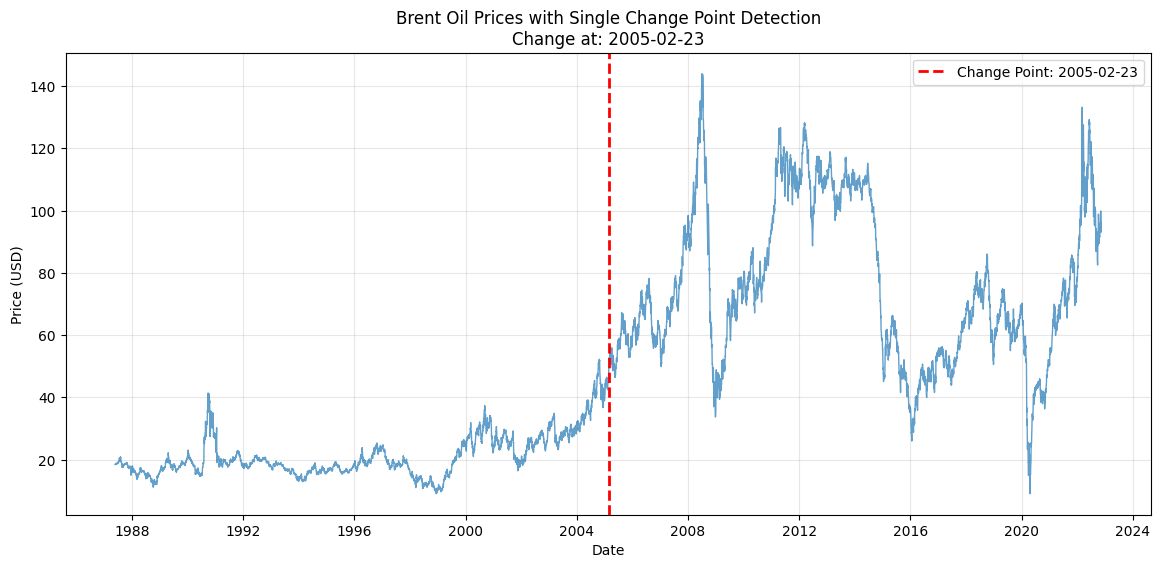

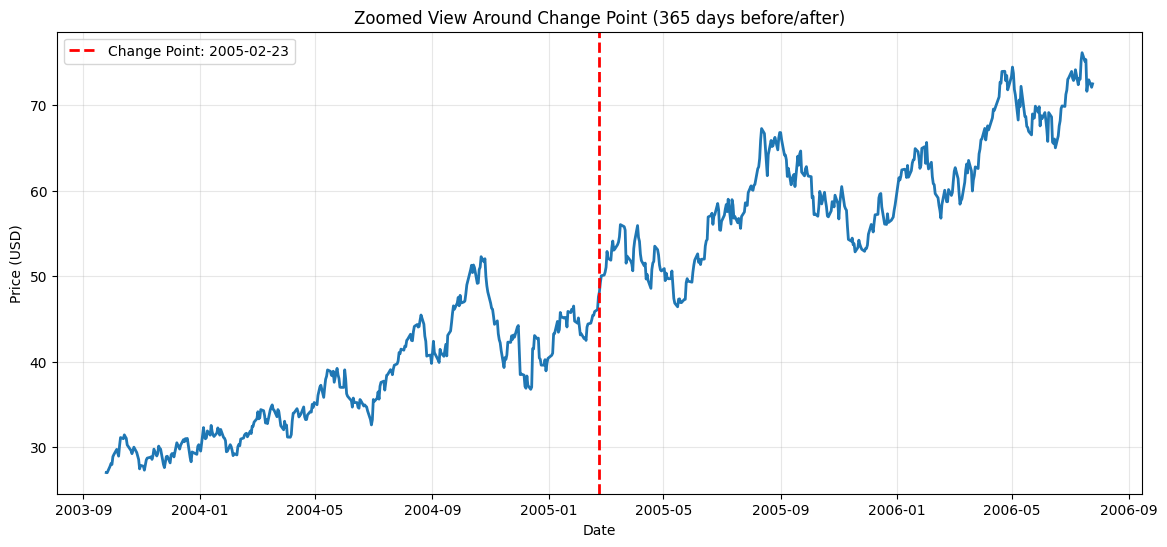

In [14]:
# Plot price with change point
plt.figure(figsize=(14, 6))

# Plot prices
plt.plot(df['Date'], df['Price'], linewidth=1, alpha=0.7)

# Mark change point
plt.axvline(x=change_date, color='red', linestyle='--', 
           linewidth=2, label=f'Change Point: {change_date.date()}')

# Add labels
plt.title(f'Brent Oil Prices with Single Change Point Detection\nChange at: {change_date.date()}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom around change point
plt.figure(figsize=(14, 6))
window_days = 365  # 1 year before and after

# Find index range
idx = most_probable_tau
start_idx = max(0, idx - window_days)
end_idx = min(len(df), idx + window_days)

# Plot zoomed view
plt.plot(df['Date'].iloc[start_idx:end_idx], 
         df['Price'].iloc[start_idx:end_idx], 
         linewidth=2)

plt.axvline(x=change_date, color='red', linestyle='--', 
           linewidth=2, label=f'Change Point: {change_date.date()}')

plt.title(f'Zoomed View Around Change Point ({window_days} days before/after)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Get mean prices before and after change
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()

# Calculate average means
avg_mu1 = mu1_samples.mean()
avg_mu2 = mu2_samples.mean()

# Calculate percentage change
percent_change = ((avg_mu2 - avg_mu1) / avg_mu1) * 100

print("=== QUANTIFIED IMPACT ===")
print(f"Average price BEFORE change: ${avg_mu1:.2f}")
print(f"Average price AFTER change: ${avg_mu2:.2f}")
print(f"Absolute change: ${avg_mu2 - avg_mu1:.2f}")
print(f"Percentage change: {percent_change:.1f}%")

# Calculate uncertainty (95% credible interval)
mu1_ci = np.percentile(mu1_samples, [2.5, 97.5])
mu2_ci = np.percentile(mu2_samples, [2.5, 97.5])

print(f"\n95% Credible Intervals:")
print(f"μ₁ (before): ${mu1_ci[0]:.2f} to ${mu1_ci[1]:.2f}")
print(f"μ₂ (after): ${mu2_ci[0]:.2f} to ${mu2_ci[1]:.2f}")

=== QUANTIFIED IMPACT ===
Average price BEFORE change: $21.44
Average price AFTER change: $75.60
Absolute change: $54.17
Percentage change: 252.7%

95% Credible Intervals:
μ₁ (before): $20.88 to $22.01
μ₂ (after): $75.04 to $76.16


In [20]:
# Load events from Task 1
events_df = pd.read_csv('../data/events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

print(f"Loaded {len(events_df)} events")
print(events_df.head())

Loaded 13 events
        Date                 Event Name                           Description  \
0 2020-03-09          COVID-19 pandemic  Global lockdowns reduced oil demand    
1 2014-06-01  OPEC maintains production   Kept output high despite oversupply   
2 2011-02-15                Arab Spring  Political instability in Middle East   
3 2008-09-15    Global Financial Crisis      Economic collapse reduced demand   
4 2003-03-20                   Iraq War    Invasion disrupted Middle East oil   

     Impact Type  
0       Economic  
1  OPEC Decision  
2      Political  
3       Economic  
4       Conflict  


In [23]:
# Find events within a window of the change point
window_days = 30  # Look 30 days before/after

nearby_events = []
for _, event in events_df.iterrows():
    days_diff = abs((event['Date'] - change_date).days)
    if days_diff <= window_days:
        nearby_events.append({
            'Event': event['Event Name'],
            'Event Date': event['Date'].date(),
            'Days from Change': days_diff,
            'Impact Type': event['Impact Type']
        })

# Create dataframe
nearby_df = pd.DataFrame(nearby_events)

if len(nearby_df) > 0:
    print(f"Found {len(nearby_df)} events within {window_days} days of change point:")
    print(nearby_df)
else:
    print(f"No events found within {window_days} days of change point.")
    
    # Find closest event anyway
    events_df['days_diff'] = abs((events_df['Date'] - change_date).dt.days)
    closest_event = events_df.loc[events_df['days_diff'].idxmin()]
    
    print(f"\nClosest event: {closest_event['Event Name']}")
    print(f"Event date: {closest_event['Date'].date()}")
    print(f"Days difference: {closest_event['days_diff']} days")

No events found within 30 days of change point.

Closest event: Iraq War
Event date: 2003-03-20
Days difference: 706 days


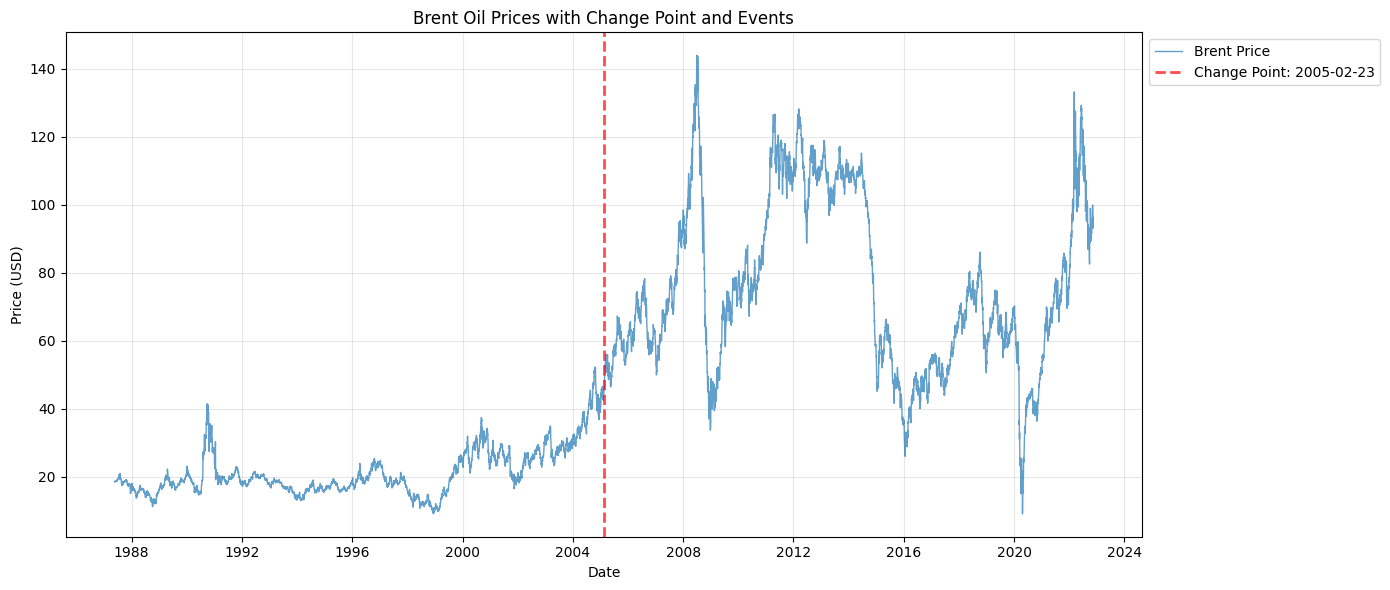

In [24]:
# Plot with events marked
plt.figure(figsize=(14, 6))

# Plot prices
plt.plot(df['Date'], df['Price'], linewidth=1, alpha=0.7, label='Brent Price')

# Mark change point
plt.axvline(x=change_date, color='red', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Change Point: {change_date.date()}')

# Mark nearby events
if len(nearby_df) > 0:
    colors = ['green', 'blue', 'orange', 'purple', 'brown']
    for i, (_, event) in enumerate(nearby_df.iterrows()):
        plt.axvline(x=pd.Timestamp(event['Event Date']), 
                   color=colors[i % len(colors)], 
                   linestyle=':', 
                   linewidth=1.5, 
                   alpha=0.7,
                   label=f"Event: {event['Event']}")

plt.title('Brent Oil Prices with Change Point and Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

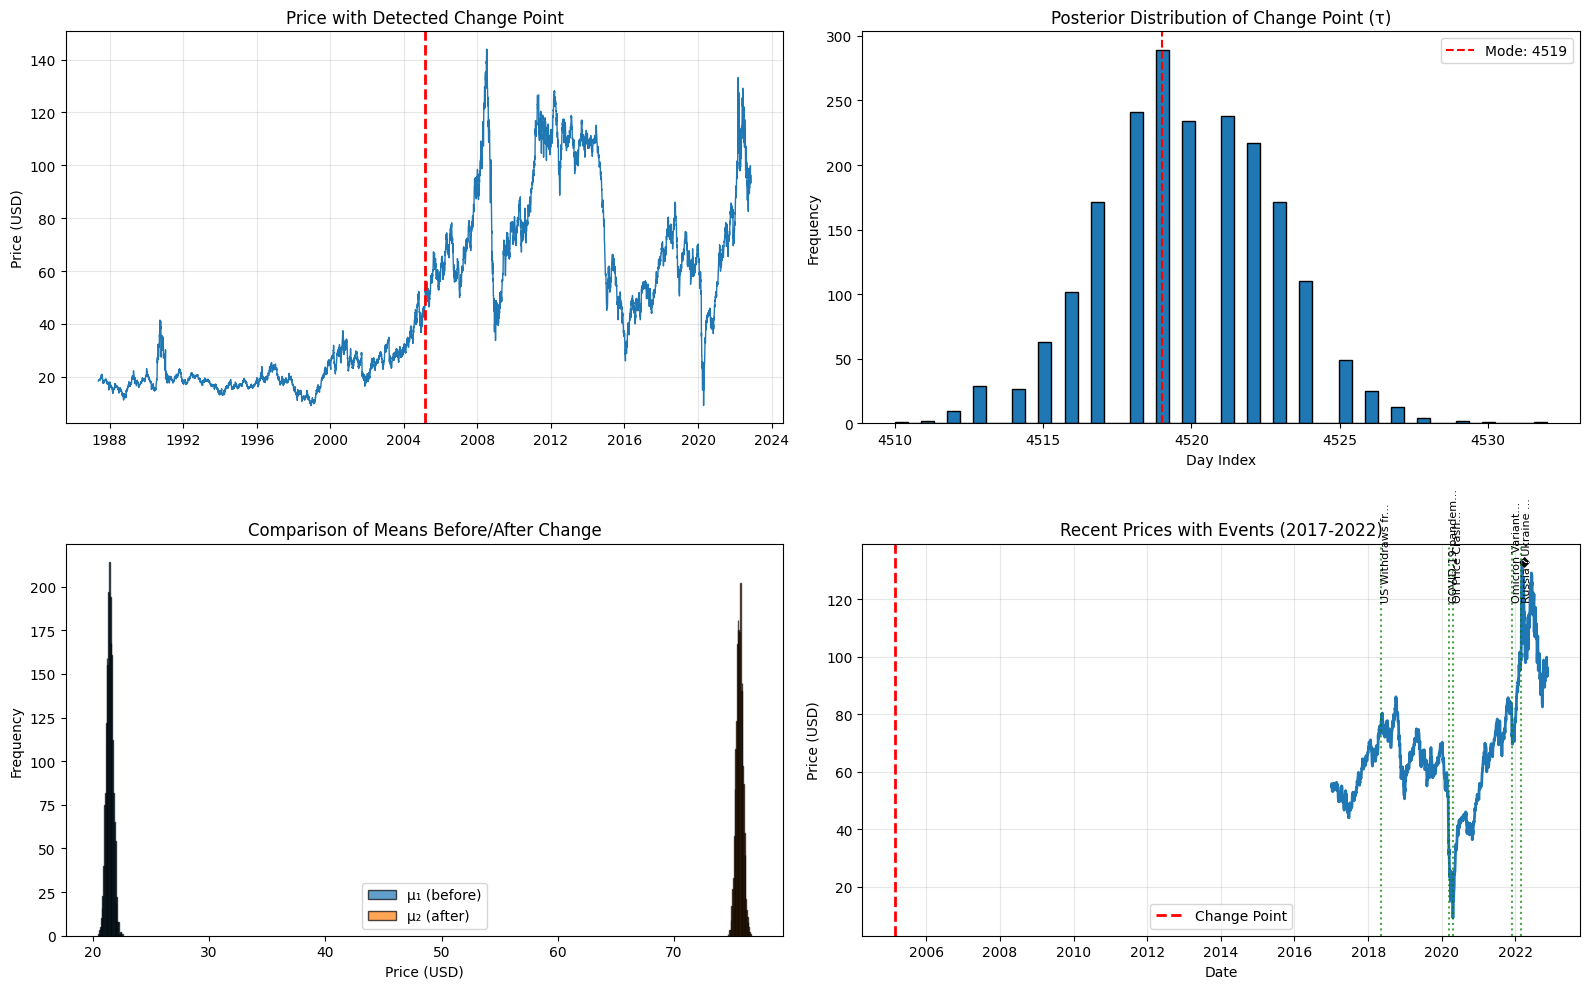

In [28]:
# Create a summary figure
fig = plt.figure(figsize=(16, 10))

# 1. Price with change point
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df['Date'], df['Price'], linewidth=1)
ax1.axvline(x=change_date, color='red', linestyle='--', linewidth=2)
ax1.set_title('Price with Detected Change Point')
ax1.set_ylabel('Price (USD)')
ax1.grid(True, alpha=0.3)

# 2. Tau posterior distribution
ax2 = plt.subplot(2, 2, 2)
ax2.hist(trace.posterior['tau'].values.flatten(), bins=50, edgecolor='black')
ax2.set_title('Posterior Distribution of Change Point (τ)')
ax2.set_xlabel('Day Index')
ax2.set_ylabel('Frequency')
ax2.axvline(x=most_probable_tau, color='red', linestyle='--', label=f'Mode: {most_probable_tau}')
ax2.legend()

# 3. Means comparison
ax3 = plt.subplot(2, 2, 3)
ax3.hist(trace.posterior['mu1'].values.flatten(), bins=30, alpha=0.7, label='μ₁ (before)', edgecolor='black')
ax3.hist(trace.posterior['mu2'].values.flatten(), bins=30, alpha=0.7, label='μ₂ (after)', edgecolor='black')
ax3.set_title('Comparison of Means Before/After Change')
ax3.set_xlabel('Price (USD)')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Event timeline
ax4 = plt.subplot(2, 2, 4)
# Plot last 5 years for clarity
recent_df = df[df['Date'] > pd.Timestamp('2017-01-01')]
ax4.plot(recent_df['Date'], recent_df['Price'], linewidth=2)
ax4.axvline(x=change_date, color='red', linestyle='--', linewidth=2, label='Change Point')

# Add event markers if any events in this period
recent_events = events_df[events_df['Date'] > pd.Timestamp('2017-01-01')]
for _, event in recent_events.iterrows():
    ax4.axvline(x=event['Date'], color='green', linestyle=':', alpha=0.7)
    ax4.text(event['Date'], recent_df['Price'].max() * 0.9, 
             event['Event Name'][:15] + '...', 
             rotation=90, fontsize=8)

ax4.set_title('Recent Prices with Events (2017-2022)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price (USD)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('change_point_summary.png', dpi=150, bbox_inches='tight')
plt.show()